This project aims to create a neural network capable of estimating DoA from telecommunications signals.

To do so, the training dataset consists of In-Phase and Quadrature (IQ) samples and Angle of Arrival (AoA) measures.
IQ samples consists

In [28]:
# Import dependencies
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import layers, models
import os
from keras.optimizers import Adam

In [29]:
# Set dataset path variable
signals_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Signalsbluetooth_signals_dataset_2024-02-26_23-37-54.csv"
)
# Set dataset path variable
angles_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Anglesbluetooth_signals_dataset_2024-02-26_23-37-54.csv"
)

In [30]:
# Load dataset
signal_dataset = pd.read_csv(signals_dataset_path, header=None)
signals_dataset_transposed = signal_dataset.transpose()

angles_dataset = pd.read_csv(angles_dataset_path, header=None)

data = result_df = pd.concat([angles_dataset, signals_dataset_transposed], axis=1)

In [31]:
# Extract features (IQ samples) and labels (Angles)
X_complex_str = data.iloc[:, 1:].values.astype(str)
# Replace 'i' with 'j'
X_complex_str = np.char.replace(X_complex_str, 'i', 'j')
# Convert to np.complex128
X_complex_linear = X_complex_str.astype(np.complex128)
X_complex = X_complex_linear.reshape((X_complex_linear.shape[0],4,4))
X_cov = np.array([np.cov(member, rowvar=False) for member in X_complex])
y_str = data.iloc[:, 0].values

# Separate real and imaginary parts for features
X_cov_real = np.real(X_cov)
X_cov_imag = np.imag(X_cov)

# Combine real and imaginary parts into a single array for features
X_cov_combined = np.stack((X_cov_real, X_cov_imag), axis=-1)

# Convert string representations of complex numbers to actual complex values for labels
y = np.array([int(val) for val in y_str])

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cov_combined, y, test_size=0.2, shuffle=True)

In [55]:
from keras.models import Model
from keras.layers import Input

real_input = Input(shape = (4,4,1))
real_conv_1 = layers.Conv2D(filters=256, strides=(1, 1), kernel_size = (3,3), activation='tanh')(real_input)
real_batch_norm_1 = layers.BatchNormalization()(real_conv_1)
real_max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(real_batch_norm_1)
real_flatten = layers.Flatten()(real_max_pool_1)


imag_input = Input(shape = (4,4,1))
imag_conv1 = layers.Conv2D(filters=256, strides=(1, 1), kernel_size = (3,3), activation='tanh')(imag_input)
imag_batch_norm_1 = layers.BatchNormalization()(imag_conv1)
imag_max_pool1 = layers.MaxPooling2D(pool_size=(2,2))(imag_batch_norm_1)
imag_flatten = layers.Flatten()(imag_max_pool1)

merge = layers.Concatenate()([real_flatten,imag_flatten])

# Fully connected layer with 512 neurons, 'linear' activation function, and batch normalization
dense_1024 = layers.Dense(1024, activation='linear')(merge)
dropout_1 = layers.Dropout(0.5)(dense_1024)

# Fully connected layer with 256 neurons, 'linear' activation function, and batch normalization
dense_256 = layers.Dense(256, activation='linear')(dropout_1)
dropout_2 = layers.Dropout(0.5)(dense_256)

# Output layer with one value 'linear' activation function for categorical classification
output = layers.Dense(1, activation='linear')(dropout_2)

model = Model(inputs = [real_input, imag_input], outputs = output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print a summary of the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4, 4, 1)]            0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 4, 4, 1)]            0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 2, 2, 256)            2560      ['input_5[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 2, 2, 256)            2560      ['input_6[0][0]']             
                                                                                            

In [33]:
# # Model architecture
# model = models.Sequential()
# # Conv2D layer
# model.add(layers.Conv2D(filters=256, strides=(1, 1), kernel_size = (3,3), input_shape=X_train.shape[1:], activation='sigmoid'))
# model.add(layers.BatchNormalization())

# # Flatten the input for the fully connected layers
# model.add(layers.Flatten())

# # Fully connected layer with 512 neurons, 'relu' activation function, and batch normalization
# model.add(layers.Dense(1024, activation='linear'))
# model.add(layers.Dropout(0.5))

# # Fully connected layer with 256 neurons, 'linear' activation function, and batch normalization
# model.add(layers.Dense(256, activation='linear'))
# model.add(layers.Dropout(0.5))

# # Output layer with one value 'linear' activation function for categorical classification
# model.add(layers.Dense(1, activation='linear'))

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# # Print a summary of the model architecture
# model.summary()

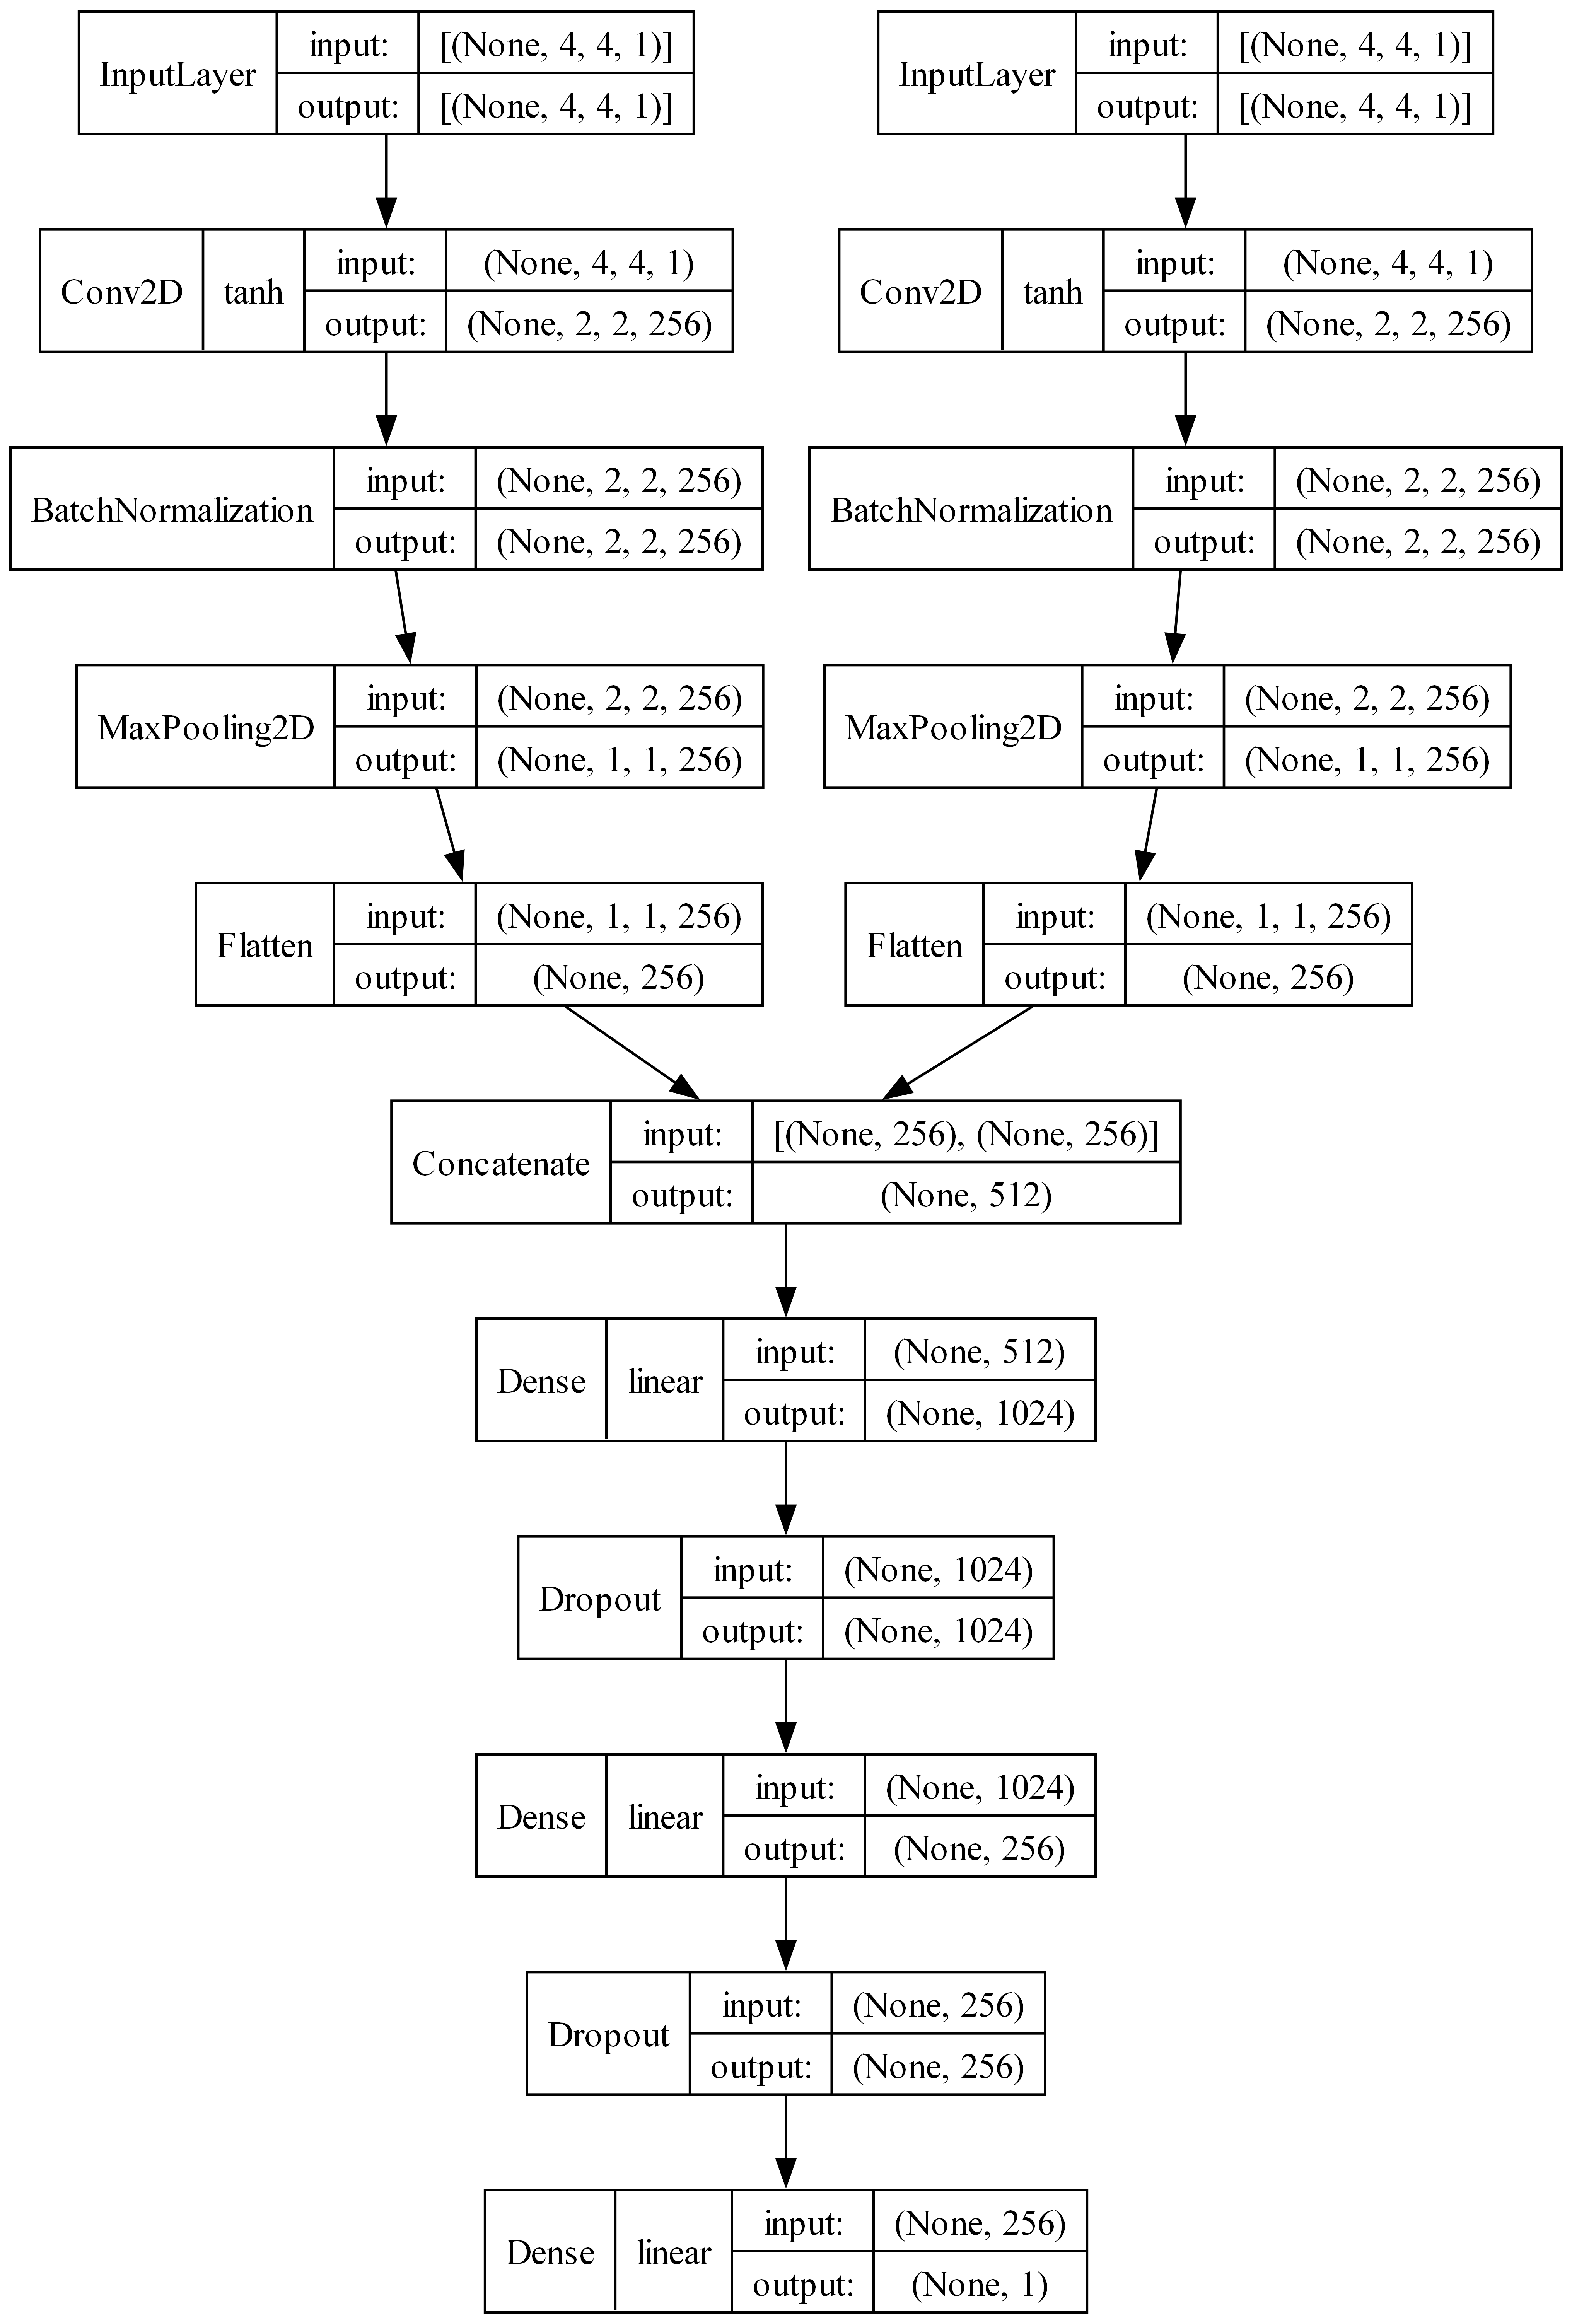

In [56]:
keras.utils.plot_model(
    model, 
    show_layer_names=False,
    show_shapes=True,
    show_layer_activations=True,
    dpi=480
)

In [57]:
import tensorflow as tf
# Train the model
x_train_input = [X_train[:, :, :, 0:1],X_train[:, :, :, 1:2]]
history = model.fit(x_train_input,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )],
                    verbose=2)

Epoch 1/100
724/724 - 10s - loss: 422.7526 - mae: 16.8901 - val_loss: 333.0485 - val_mae: 15.3755 - 10s/epoch - 14ms/step
Epoch 2/100
724/724 - 8s - loss: 335.1576 - mae: 15.0648 - val_loss: 385.1784 - val_mae: 16.1868 - 8s/epoch - 11ms/step
Epoch 3/100
724/724 - 8s - loss: 295.2052 - mae: 13.8303 - val_loss: 2806.6421 - val_mae: 50.5202 - 8s/epoch - 11ms/step
Epoch 4/100
724/724 - 8s - loss: 288.2685 - mae: 13.5895 - val_loss: 1700.7499 - val_mae: 37.8068 - 8s/epoch - 11ms/step
Epoch 5/100
724/724 - 8s - loss: 274.1934 - mae: 13.1297 - val_loss: 411.2105 - val_mae: 18.5808 - 8s/epoch - 11ms/step
Epoch 6/100
724/724 - 8s - loss: 270.7839 - mae: 12.8986 - val_loss: 273.5317 - val_mae: 10.9200 - 8s/epoch - 11ms/step
Epoch 7/100
724/724 - 8s - loss: 263.6475 - mae: 12.6194 - val_loss: 1608.1703 - val_mae: 37.0617 - 8s/epoch - 11ms/step
Epoch 8/100
724/724 - 7s - loss: 264.0694 - mae: 12.6225 - val_loss: 246.1410 - val_mae: 10.3144 - 7s/epoch - 10ms/step
Epoch 9/100
724/724 - 8s - loss: 25

In [58]:
# Evaluate the model on the test set
x_test_input = [X_test[:, :, :, 0:1],X_test[:, :, :, 1:2]]
loss, mae = model.evaluate(x_test_input, y_test)
print(f'Test Mean Absolute Error: {mae}')

227/227 [==============================] - 1s 4ms/step - loss: 236.1338 - mae: 10.0693
Test Mean Absolute Error: 10.069340705871582


In [59]:
# Predictions on the test set
predictions = model.predict(x_test_input)

227/227 [==============================] - 1s 3ms/step


In [60]:
print("|Estimated| x |Actual| x |diff|")
for i in range(len(predictions)):
    print(f'|{int(predictions[i])}|,|{y_test[i]} | {abs(y_test[i]-int(predictions[i]))}')

#Adicionar ruido (mais de um tipo (-140 a -100db)), estimar 20 entradas de cada angulo e 

|Estimated| x |Actual| x |diff|
|46|,|51 | 5
|45|,|50 | 5
|71|,|80 | 9
|45|,|51 | 6
|58|,|61 | 3
|7|,|12 | 5
|59|,|62 | 3
|63|,|35 | 28
|71|,|81 | 10
|69|,|73 | 4
|71|,|87 | 16
|48|,|54 | 6
|36|,|22 | 14
|46|,|52 | 6
|68|,|33 | 35
|66|,|27 | 39
|71|,|77 | 6
|65|,|67 | 2
|65|,|67 | 2
|56|,|60 | 4
|54|,|58 | 4
|16|,|19 | 3
|46|,|43 | 3
|53|,|39 | 14
|71|,|79 | 8
|71|,|29 | 42
|70|,|74 | 4
|71|,|84 | 13
|9|,|17 | 8
|29|,|21 | 8
|69|,|28 | 41
|64|,|66 | 2
|55|,|59 | 4
|45|,|50 | 5
|44|,|49 | 5
|71|,|86 | 15
|65|,|67 | 2
|71|,|84 | 13
|57|,|25 | 32
|50|,|55 | 5
|2|,|4 | 2
|62|,|64 | 2
|68|,|71 | 3
|70|,|32 | 38
|46|,|43 | 3
|69|,|28 | 41
|3|,|5 | 2
|44|,|46 | 2
|65|,|34 | 31
|58|,|61 | 3
|0|,|0 | 0
|62|,|64 | 2
|52|,|57 | 5
|44|,|46 | 2
|54|,|58 | 4
|57|,|60 | 3
|71|,|81 | 10
|0|,|1 | 1
|57|,|37 | 20
|36|,|22 | 14
|64|,|66 | 2
|17|,|19 | 2
|62|,|26 | 36
|3|,|5 | 2
|29|,|21 | 8
|71|,|80 | 9
|3|,|5 | 2
|44|,|45 | 1
|50|,|24 | 26
|45|,|44 | 1
|6|,|14 | 8
|66|,|27 | 39
|52|,|57 | 5
|50|,|55 | 5

C:\Users\Marli\AppData\Local\Temp\ipykernel_19104\498507051.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'|{int(predictions[i])}|,|{y_test[i]} | {abs(y_test[i]-int(predictions[i]))}')


In [61]:
len(set([int(predictions[j]) for j in range(len(predictions))]))

C:\Users\Marli\AppData\Local\Temp\ipykernel_19104\3110605697.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  len(set([int(predictions[j]) for j in range(len(predictions))]))


45

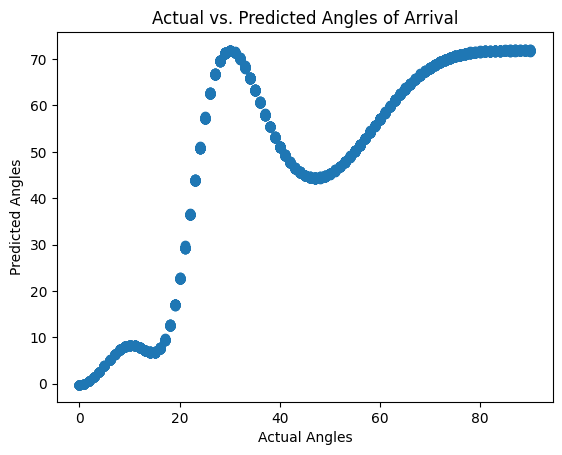

In [62]:
import matplotlib.pyplot as plt

# Visualize predictions
plt.scatter(y_test, predictions)
plt.title('Actual vs. Predicted Angles of Arrival')
plt.xlabel('Actual Angles')
plt.ylabel('Predicted Angles')
plt.show()

In [47]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient
correlation, _ = pearsonr(y_test, predictions.flatten())
print(f'Correlation Coefficient: {correlation}')

Correlation Coefficient: 0.8254837658180689
